In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read gene expression
x = pd.read_csv('/Users/hclimente/data/single_cell/habib/DATA_MATRIX_LOG_TPM.txt', sep = '\t')
featnames = x.pop('GENE').tolist()

# read phenotypes
meta = pd.read_csv('/Users/hclimente/data/single_cell/habib/CLUSTER_AND_SUBCLUSTER_INDEX.txt', sep = '\t')
meta = meta.set_index('NAME')
cell_lines = meta['CLUSTER'].to_dict()
y = np.array([ cell_lines.get(c,None) for c in x.columns ])

# remove unknown clusters
x = x.values[:,y != 'Non']
y = y[y != 'Non']
y = pd.factorize(y)[0]

# subset expression to selected features
hl = pd.read_csv('../results/single_cell/habib_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt', sep = '\t', header=None)
x_hl = x[[ x in list(hl[0]) for x in featnames ]]

# Supervised learning

In [3]:
clf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'log2'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

cv_clf = GridSearchCV(clf, param_grid, cv=3)
cv_clf.fit(x_hl.T, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 500], 'max_features': ['auto', 'log2'], 'max_depth': [4, 6, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [4]:
importances = cv_clf.best_estimator_.feature_importances_
std = np.std([cv_clf.best_estimator_.feature_importances_ for tree in cv_clf.best_estimator_.estimators_],
              axis=0)

indices = np.argsort(importances)
genes = hl.values[indices].flatten()

In [5]:
importances.shape

(50,)

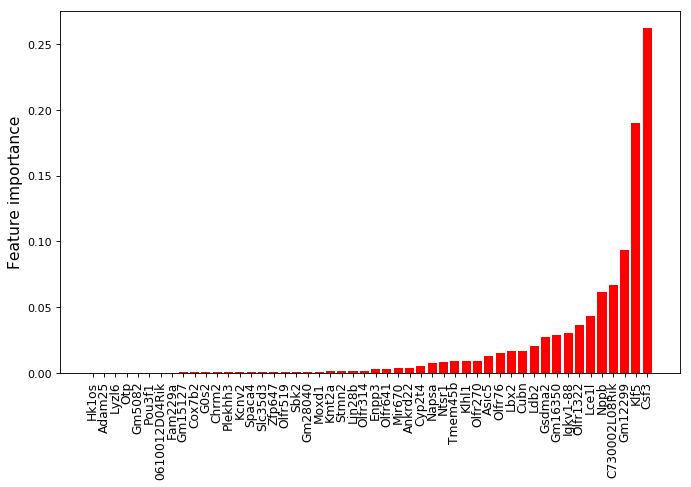

In [6]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

plt.bar(genes, importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(genes)), genes, rotation=90, fontsize=11)
plt.ylabel('Feature importance', fontsize=14)

plt.savefig("img/supp_figure_3.pdf", bbox_inches='tight')

# Unsupervised learning

In [7]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

palette = [ sns.color_palette("hls", 7)[x] for x in y ]

centered_x = (x.T - np.mean(x.T, axis = 0)).T
pca = PCA(n_components = 30).fit(centered_x)

## t-SNE

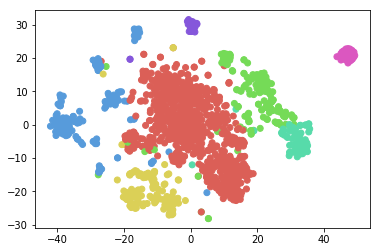

In [8]:
tsne_embedding = TSNE(n_components=2, perplexity=50).fit_transform(pca.components_.T)
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')

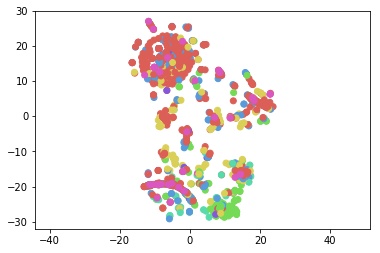

In [9]:
tsne_hl_embedding = TSNE(n_components=2, perplexity=50).fit_transform(x_hl.T)
plt.scatter(tsne_hl_embedding[:,0], tsne_hl_embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')

## UMAP

/Users/hclimente/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


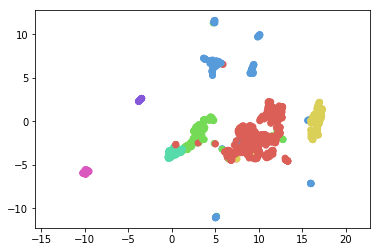

In [10]:
embedding = umap.UMAP(n_neighbors=6).fit_transform(pca.components_.T)

plt.scatter(embedding[:,0], embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')

/Users/hclimente/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


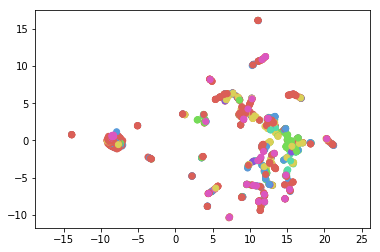

In [11]:
embedding = umap.UMAP(n_neighbors=6).fit_transform(x_hl.T)

plt.scatter(embedding[:,0], embedding[:,1], c=palette)
plt.gca().set_aspect('equal', 'datalim')